In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import seaborn as sb

Notebook is based on: https://sungsoo.github.io/2018/04/11/predicting-car-prices.html

##1. Introduction

Let’s walk through an example of predictive analytics using a data set that most people can relate to:prices of cars. In this case, we have a data set with historical Toyota Corolla prices along with related car attributes.

In the data set, we find the following variables:

* Price
* Age
* KM(kilometers driven)
* Fuel Type
* HP(horsepower)
* Automatic or Manual
* Number of Doors
* Weight(in pounds)

are collected for a number of vehicles in a CSV file for Toyota Corollas. You can download this dataset from the original author's github account here: https://github.com/datailluminations/PredictingToyotaPricesBlog

In **predictive models**, there is a response variable (also called dependent variable), which is the variable that we are interested in predicting.

The **independent variables** (the predictors, also called **features** in the machine learning community) are one or more numeric variables we are using to predict the response variable. Given we are using a linear regression model, we are assuming the relationship between the independent and dependent variables follow a straight line. Later, one could examine more complex models to see if it improves predictive powers.

But before we start our modeling exercise, it’s good to take a visual look at what we are trying to predict to see what it looks like. Since we are trying to predict Toyota Corolla prices with historical data, let’s do a simple histogram plot to see the distribution of Corolla prices (or another variable of our choosing):

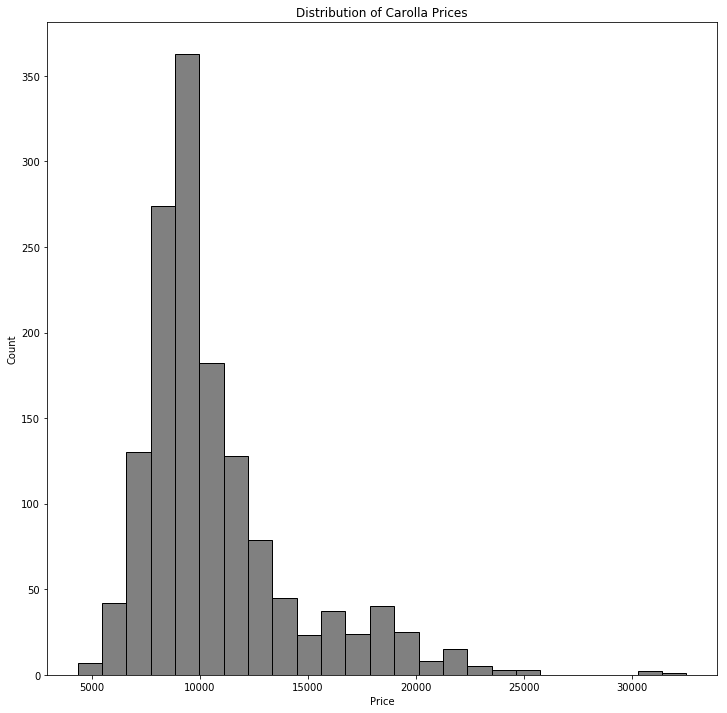

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight,FuelType1,FuelType2
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,0.0,0.0
mean,10730.824513,55.947075,68533.259749,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961,NaN,NaN
std,3626.964585,18.599988,37506.448872,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112,NaN,NaN
min,4350.000000,1.000000,1.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000,NaN,NaN
25%,8450.000000,44.000000,43000.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000,NaN,NaN
50%,9900.000000,61.000000,63389.500000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000,NaN,NaN
75%,11950.000000,70.000000,87020.750000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000,NaN,NaN
max,32500.000000,80.000000,243000.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000,NaN,NaN


In [2]:
file= 'https://raw.githubusercontent.com/datailluminations/PredictingToyotaPricesBlog/master/ToyotaCorolla.csv'
carData= pd.read_csv(file)
df= pd.DataFrame(carData, columns= ['Price', 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2'])

price= df['Price']
age= df['Age']
km= df['KM']
fuelType= df['FuelType']
hp= df['HP']
metColor= df['MetColor']
automatic= df['Automatic']
cc= df['CC']
doors= df['Doors']
weight= df['Weight']

plt.figure(figsize= (12,12))
plt.hist(price, bins=25, color= 'grey', edgecolor= 'black'); plt.xlabel("Price"); plt.ylabel("Count"); plt.title("Distribution of Carolla Prices")
#plt.hist(age, bins=25, color= 'grey', edgecolor= 'black'); plt.xlabel("Age"); plt.ylabel("Count")
#plt.hist(km, bins=25, color= 'grey', edgecolor= 'black'); plt.xlabel("KM"); plt.ylabel("Count")
#plt.hist(hp, bins=25, color= 'grey', edgecolor= 'black'); plt.xlabel("HP"); plt.ylabel("Count")
#plt.hist(metColor, bins=2, color= 'grey', edgecolor= 'black'); plt.xlabel("Metallic Color"); plt.ylabel("Count")
#plt.hist(automatic, bins=2, color= 'grey', edgecolor= 'black'); plt.xlabel("Manual (0) or Automatic (1)"); plt.ylabel("Count")
#plt.hist(cc, bins=25, color= 'grey', edgecolor= 'black'); plt.xlabel("Cubic Centimeters"); plt.ylabel("Count")
#plt.hist(doors, bins=6, color= 'grey', edgecolor= 'black'); plt.xlabel("Number of Doors"); plt.ylabel("Count")
#plt.hist(weight, bins=25, color= 'grey', edgecolor= 'black'); plt.xlabel("Weight"); plt.ylabel("Count")
plt.show()
df.describe() # show feature statistics


We see that most used Corollas are around \$10K and there are some at the tail end that over \$25K. These might be newer cars with a lot of options. 

#2. Data Transformation

One of the main steps in the predictive analytics is data transformation. Data is seldom arranged in the way you want them. One might have to do some kinds of transformations to get it to the way we need them to be either because the data is dirty, not of the type we want, out of bounds, and a host of other reasons.

In this case, we need to convert the categorical variables to numeric variables to feed into our linear regression model, because linear regression models only take numeric variables.

The categorical variable we want to do the transformation on is Fuel Types. We that there are 3 Fuel Types: 1) CNG 2) Diesel 3) Petrol

In [4]:
CNG= np.sum(fuelType== "CNG")
Diesel= np.sum(fuelType== "Diesel")
Petrol= np.sum(fuelType== "Petrol")
print("CNG: " + str(CNG) + " , Diesel: " + str(Diesel) + " , Petrol: " + str(Petrol))

CNG: 17 , Diesel: 155 , Petrol: 1264


So, we can convert the categorical variable Fuel Type to two numeric variables: FuelType1 and FuelType2. We assign CNG to a new variable FuelType1 in which a 1 represents it’s a CNG vehicle and 0 it’s not. Likewise, we assign Diesel to a new variable FuelType2 in which a 1 represents it’s a Diesel vehicle and 0 it’s not.

So, what do we do with PETROL vehicles? We could have introduced a third varialbe (e.g. FuelType3), but here we will represent PETROL by the case when BOTH FuelType1 and FuelType2 are zero.

In [5]:
# Convert categorical variables to integer so we can use in our model

fuelType1= (fuelType== "CNG")* 1  # multiple by 1 to ensure numeric representation True* 1 = 1, False* 1= 0
fuelType2= (fuelType== "Diesel")* 1

# Add these new variables to our DataFrame
df["FuelType1"]= fuelType1
df["FuelType2"]= fuelType2
print(df.head())

   Price  Age     KM FuelType  HP  ...    CC  Doors  Weight  FuelType1  FuelType2
0  13500   23  46986   Diesel  90  ...  2000      3    1165          0          1
1  13750   23  72937   Diesel  90  ...  2000      3    1165          0          1
2  13950   24  41711   Diesel  90  ...  2000      3    1165          0          1
3  14950   26  48000   Diesel  90  ...  2000      3    1165          0          1
4  13750   30  38500   Diesel  90  ...  2000      3    1170          0          1

[5 rows x 12 columns]


#3. Exploratory Data Analysis (EDA):

The next step in predictive analytics is to explore our underlying data structure. Let’s do a few plots of our explantory variables to see how they look against `Price`.

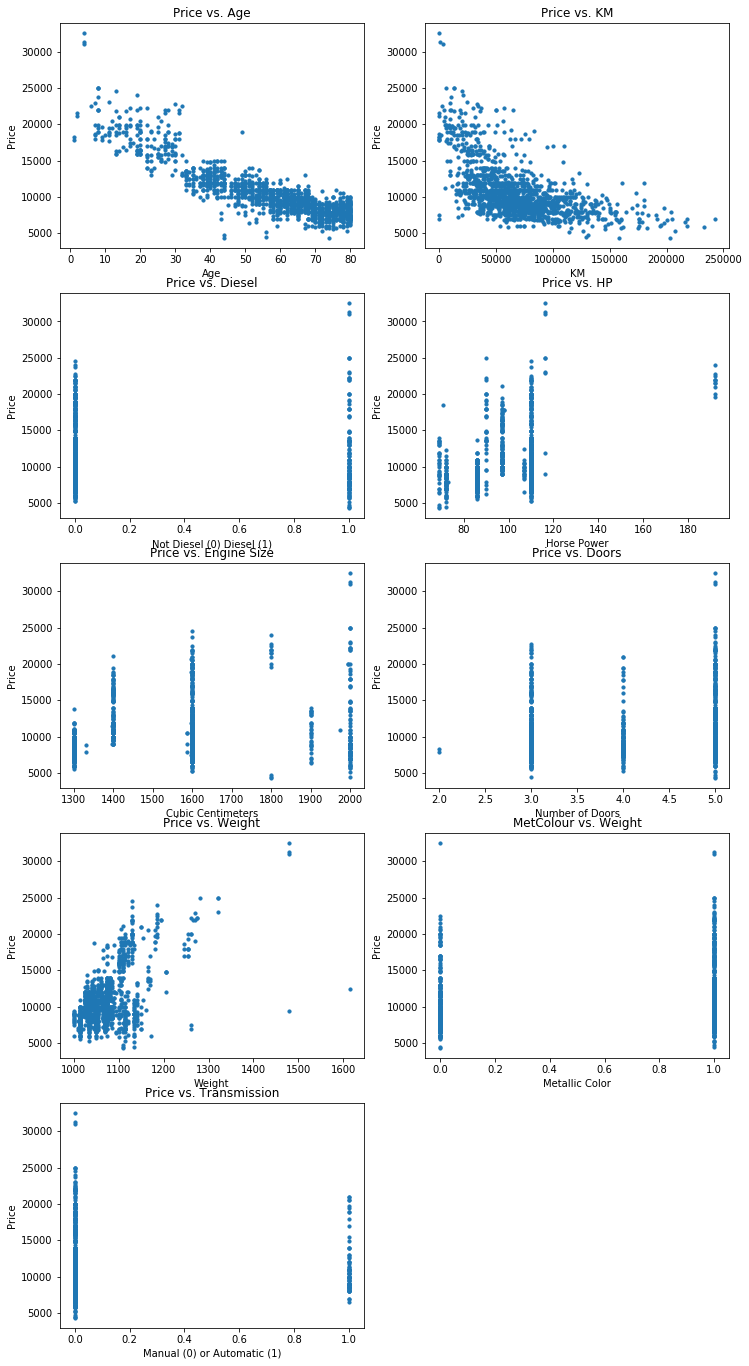

In [7]:
# Plot variables against price
plt.figure(figsize= (12,24))

plt.subplot(5, 2, 1); plt.scatter(age, price, s=10); plt.xlabel("Age"); plt.ylabel("Price"); plt.title("Price vs. Age")
plt.subplot(5, 2, 2); plt.scatter(km, price, s=10); plt.xlabel("KM"); plt.ylabel("Price"); plt.title("Price vs. KM")
plt.subplot(5, 2, 3); plt.scatter(fuelType2, price, s=10); plt.xlabel("Not Diesel (0) Diesel (1)"); plt.ylabel("Price"); plt.title("Price vs. Diesel")
plt.subplot(5, 2, 4); plt.scatter(hp, price, s=10); plt.xlabel("Horse Power"); plt.ylabel("Price"); plt.title("Price vs. HP")
plt.subplot(5, 2, 5); plt.scatter(cc, price, s=10); plt.xlabel("Cubic Centimeters"); plt.ylabel("Price"); plt.title("Price vs. Engine Size")
plt.subplot(5, 2, 6); plt.scatter(doors, price, s=10); plt.xlabel("Number of Doors"); plt.ylabel("Price"); plt.title("Price vs. Doors")
plt.subplot(5, 2, 7); plt.scatter(weight, price, s=10); plt.xlabel("Weight"); plt.ylabel("Price"); plt.title("Price vs. Weight")
plt.subplot(5, 2, 8); plt.scatter(metColor, price, s=10); plt.xlabel("Metallic Color"); plt.ylabel("Price"); plt.title("MetColour vs. Weight")
plt.subplot(5, 2, 9); plt.scatter(automatic, price, s=10); plt.xlabel("Manual (0) or Automatic (1)"); plt.ylabel("Price"); plt.title("Price vs. Transmission")
#plt.hist(metColor, bins=2, color= 'grey', edgecolor= 'black'); plt.xlabel("Metallic Color"); plt.ylabel("Count")
#plt.hist(automatic, bins=2, color= 'grey', edgecolor= 'black'); plt.xlabel("Manual (0) or Automatic (1)"); plt.ylabel("Count")
plt.show()

The above plots are telling us that:

* Newer cars tend to be more expensive (as expected)
* The more miles a car has the cheaper it is.
* Horsepower - this one is not as direct as the other. Yes, the more horsepower the more expensive. But not always the case. Let’s see how this variable will behave in our model.
* The fact that a color has a Metallic Color or not doesn’t seem to be that useful. But let’s see what the model says...
* Automatic vs manual transmission does not have much of an influence to Prices.
* The number of cyclinders (CC) plots against Price seems to show the more cyclinder the more expensive though not always the case.
* Plotting number of doors does not tell us much.
* The heavier(i.e. bigger) cars cost more though there are some outliers that doesn’t fit nicely.

#4. Model Building: Linear Regression


Now that we have explored our variables, let’s perform a simple linear regression of `Price` against all the data we’ve collected.

In [10]:
# linear regression
x= df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']] # independent variables
x= sm.add_constant(x)   # Recall that sm is 'statsmodels.api'
y1 = df['Price'] # dependent variable

model1 = sm.OLS(y1, x).fit()  # Fit our linear regression model
pred1 = model1.predict(x)  # Apply trained/learned model back to training data
 
print(model1.summary())  # Print summary stats from model fit.

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     948.0
Date:                Mon, 16 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:46:22   Log-Likelihood:                -12346.
No. Observations:                1436   AIC:                         2.471e+04
Df Residuals:                    1425   BIC:                         2.477e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2680.6851   1219.030     -2.199      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


We see from the output that our model captures 86.9% (see Multiple R square) of the variation in `price` using the explantory variables above. This is pretty decent.

However, we notice is that some coefficents are more statistically significant than others. For example, we find that `Age` is the most significant witha t-value of -46.889, followed by `Weight` with a t-value of 16.629. The least significant variables are `Metallic Color` and `Number of Doors`. This was also confirmed in our EDA (exploratory data analysis) graphs above.

Now, it’s generally NOT a good idea to use your ENTIRE data sample to fit the model. What we want to do is to train the model on a sample of the data. Then we’ll see how it perform outside of our training sample. This breaking up of our data set to training and test set is to evaluate the performance of our models with unseen data. Using the entire data set to build a model then using the entire data set to evaluate how good a model does is a bit of cheating or careless analytics.

#5. Results with Training Data:

Here is the results using the first 1000 rows of data as training sample:

In [13]:
x= df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']]
y1 = df['Price']

trainX= x[0:1000]  # take first 1000 samples of independent variables as training set
trainX = sm.add_constant(trainX) # add constant
trainY= y1[0:1000] # take first 1000 samples of price as well as training set

model2 = sm.OLS(trainY, trainX).fit() # Train model on training data
trainingResults = model2.predict(trainX) # Evaluate model on training set
 
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     628.8
Date:                Mon, 16 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:51:05   Log-Likelihood:                -8649.8
No. Observations:                1000   AIC:                         1.732e+04
Df Residuals:                     989   BIC:                         1.738e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2916.5288   1447.024     -2.016      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Interesting enough, the R-squared only changed nominally to 86.4% and the variables t-value also moved slightly. The statistically significant relationships remained the same. Good.

#6. Model Evaluation: Linear Regression

The real test of a good model is to test the model with data that it has not been fitted. Here’s where the rubber meets the road. We apply our model to unseen data to see how it performs.

##Prediction using out-of-sample data

Here are some common metrics to see how well the model predicts using various error metrics. The main takeway is we want our forecast errors to be as small as possible. The smaller the forecast error the better the model is at predicting unseen data.

The first metric is mean absolute error (MAE). This is the average absolute value of the error observed over all test points:

In [15]:
testX= x[1000:]  # take the remaining samples of independent variables for testing set
testX = sm.add_constant(testX) # add constant
testY= y1[1000:] # take the remaining samples of price as well for testing set

testingResults = model2.predict(testX) # results of trained model on new data

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
# mean absolute error

mea= sm.tools.eval_measures.meanabs(testY, testingResults)
print("mean absolute error: %.2f" % mea)

mean absolute error: 988.87


ME is the mean error. The ideal ME is zero, which means on average the predicted value perfectly matches the actual value. This is rarely if ever the case. As in all things, we must determine what is an acceptable level of errors for our predictive analytics model and accept it. No such thing as a perfect model.

In [22]:
# root mean squared error
rmse= sm.tools.eval_measures.rmse(testY, testingResults)
print("root mean squared error: %.2f" % rmse)

root mean squared error: 1260.63


RMSE is root mean squared error. A mean squared error(MSE) is the average of the squared differences between the predicted value and the actual value. The reason we square is to not account for sign differences(negative differences and positive differences are the same thing when squared). RMSE brings it back to our normal unit by taking the square root of MSE.

In [21]:
# mean absolute percent error
mape= np.mean(np.abs((testY - testingResults) / testY)) * 100
print('mean absolute percent error: %.2f' % mape)

mean absolute percent error: 12.18


MAPE stands for mean absolute percent error and express the forecast errors in percentages. On average, our model had a forecast error of only 12.2%. Not bad for a first pass at this data set.

#8. Logistic Regression

Now let's say we want to use this data to create a model that will predict whether or not we can afford a car from the variables we have discussed. Suppose we have 10,000 dollars to spend. We use the threshold of 10,000 dollars as the criteria for assigning cars a class; class 1 if we can afford them (<= 10,000) or class 0 if we cannot.

In [25]:
# logistic regression for afford/ cannot afford

df2= df # make a copy of df to use in logistic regression
cash_on_hand= 10000 # what we can afford
price2= (price<= cash_on_hand)* 1 # create array of logical class labels based on whether or not we can afford
df2["Price"]= price2 # update price with class labels
print(df2.head())

   Price  Age     KM FuelType  HP  ...    CC  Doors  Weight  FuelType1  FuelType2
0      0   23  46986   Diesel  90  ...  2000      3    1165          0          1
1      0   23  72937   Diesel  90  ...  2000      3    1165          0          1
2      0   24  41711   Diesel  90  ...  2000      3    1165          0          1
3      0   26  48000   Diesel  90  ...  2000      3    1165          0          1
4      0   30  38500   Diesel  90  ...  2000      3    1170          0          1

[5 rows x 12 columns]


Great, now we have a binary classification problem (hopefully there are some class 1's in there!). Let's start by plotting how many of each class there are.

Text(0, 0.5, 'Count')

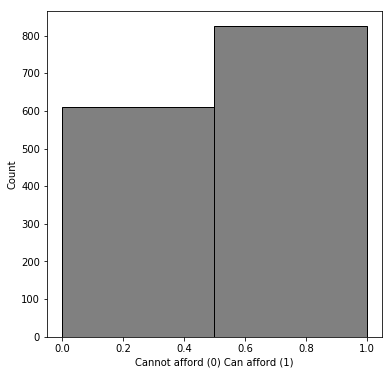

In [26]:
plt.figure(figsize= (6,6))
plt.hist(price2, bins=2, color= 'grey', edgecolor= 'black'); plt.xlabel("Cannot afford (0) Can afford (1)"); plt.ylabel("Count")

Okay, great - these two classes look relatively equal in size. Visualizing the class distribution is a good first step, because you can check for class imbalance and get an indication of how to read your classifier's accuracy. If our two classes were split 50/50 (0/1) and we scored a classification accuracy of 50%, then we know that our classifier is no better than a coin toss. If the classes were split 90/10 (0/1) and we got the same accuracy, then we would know that our classifier was better than random.

#9. Visualizing Features

Now let's look at our data again. When we visualized our data in the linear regression model, we were looking for variables that formed a linear trend with price. Now in the logistic regression, we are looking for features that separate our two classes into two groups. The greater the separation of the distributions, the better the feature.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


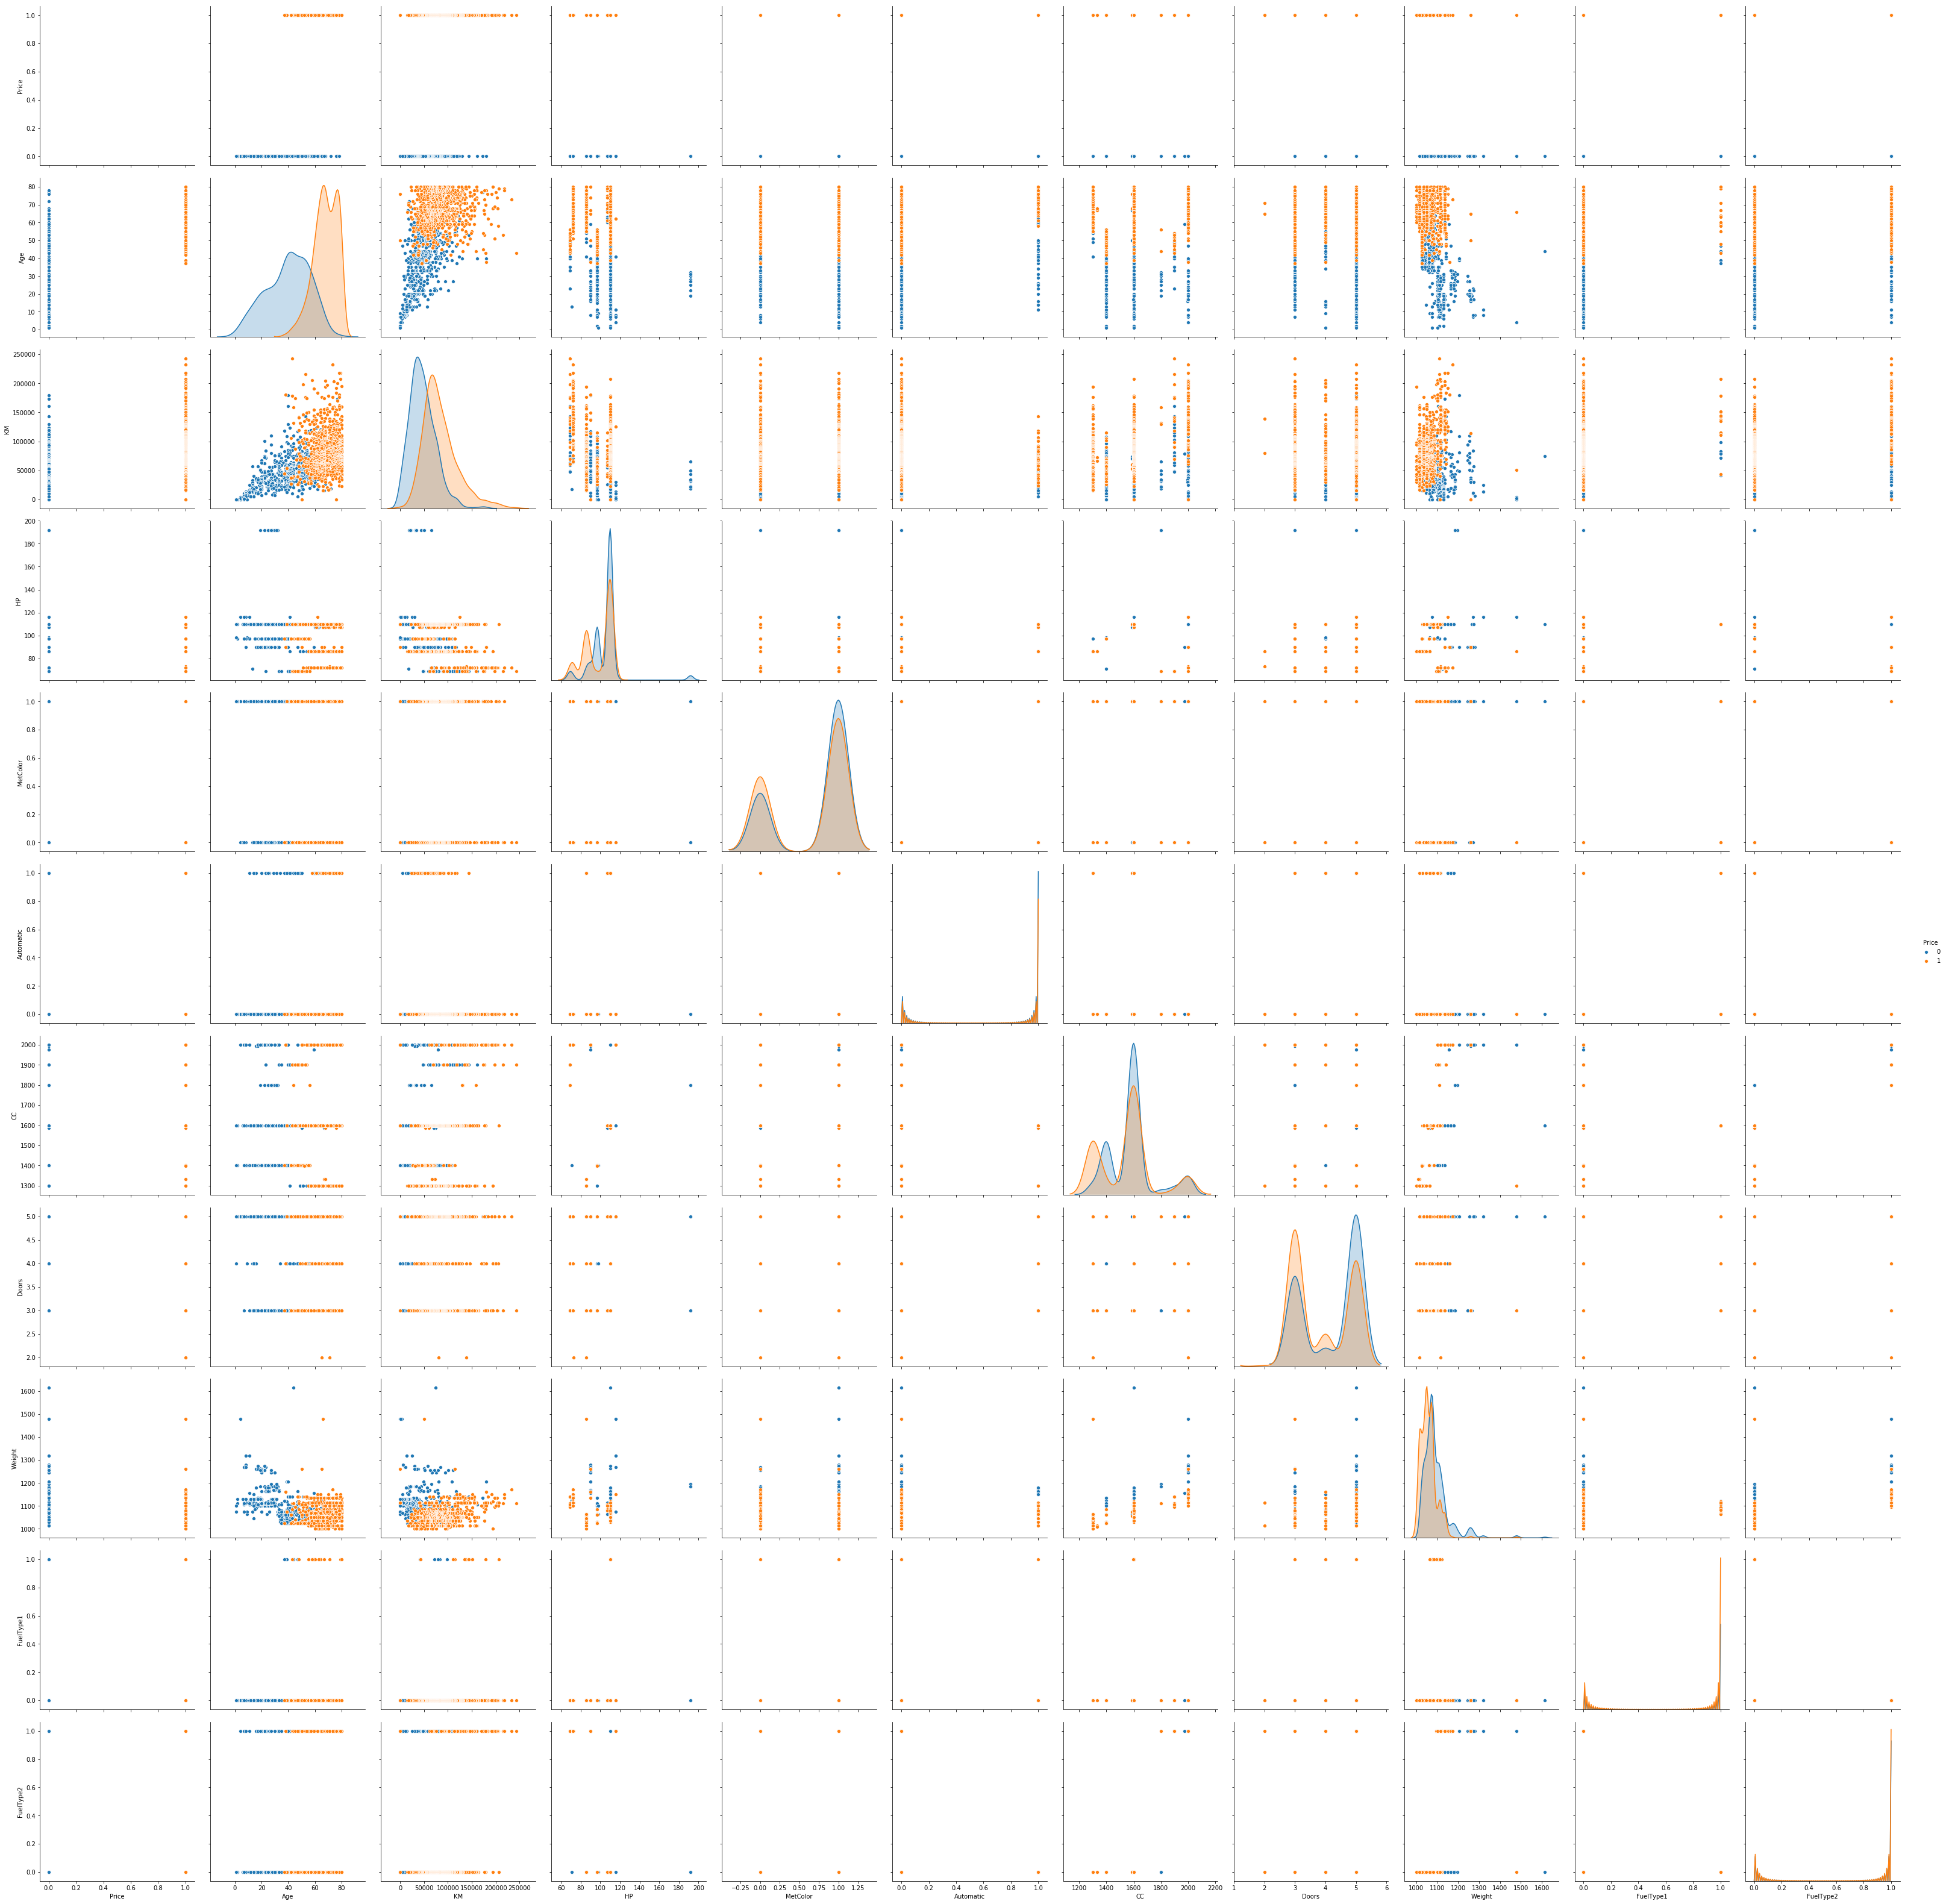

In [27]:

sb.pairplot(df2, hue='Price', height= 4)


These plots tell us that cars in class 1 tend to be: 

* older,
* have higher km,
* and have lower horsepower.

These plots also tell us, as they did in the linear regression, that `metallic color`, `transmission type`, `number of cyclinders`, `number of doors`, `weight`, and `fuel type` do not distinguish these two classes very well.

#10. Implementing the logistic regression model

Let's see what we get when we build a logistic regression classifier using these features. We'll start by making a training data set using 70% of our data and a testing data set using the remaining 30% of the data.



In [0]:
x= df2[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']]
y = df2['Price']

# Partition training and testing data sets
samples= x.shape[0] # returns number of samples
szTraining= int(samples*0.7) # 70% rounded to the nearest integer
trainX= x[0:szTraining]
trainY= y[0:szTraining]
testX= x[szTraining:]
testY= y[szTraining:]

# Construct model using all features
logitModel=sm.Logit(trainY,trainX)
result=logitModel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.301692
         Iterations 9
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.556      
Dependent Variable: Price            AIC:              626.4002   
Date:               2019-09-09 17:21 BIC:              675.5277   
No. Observations:   1005             Log-Likelihood:   -303.20    
Df Model:           9                LL-Null:          -682.34    
Df Residuals:       995              LLR p-value:      2.0307e-157
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     9.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Age             0.2058    0.0162  12.7039  0.0000   0.1741   0.2376
KM              0.0000    0.0000   5.4257  0.0000

#11. Feature selection

As we discussed earlier in our data visualizations, some features are more important than others for separating our two classes. We want to separate the good features from the bad features here. Good features make our model better, while bad features add noise that may hinder classification accuracy. 

There are many algorithms for removing bad features that we will discuss later in this class, but for now we will use the p-values in the table above. Don't worry about the details of p-values; we will cover them in more detail later. All we need to know now is that features with smaller p-values (<= 0.05) are features are useful for predicting class, and these are the ones we want to keep in our model.

Age, KM, Automatic, Doors, and Weight all have low p-values and will be kept. The rest will be discarded from our model.

In [0]:
# Select only important features to use in model
trainX2= trainX[['Age', 'KM', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1']]
logitModel=sm.Logit(trainY,trainX2) 
result=logitModel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.313687
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.538      
Dependent Variable: Price            AIC:              644.5113   
Date:               2019-09-09 17:50 BIC:              678.9005   
No. Observations:   1005             Log-Likelihood:   -315.26    
Df Model:           6                LL-Null:          -682.34    
Df Residuals:       998              LLR p-value:      2.5704e-155
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Age             0.1804    0.0136  13.2448  0.0000   0.1537   0.2071
KM              0.0000    0.0000   7.4833  0.0000

# 12. Training


With the other noisy features removed, the p-values for CC and FuelType1 have shot up. Let's remove these now and train our final model on the remaining features. We will then move to testing the model on our test data set and evaluate its performance.

In [0]:
# Trim more poor features and train final model
trainX2= trainX[['Age', 'KM', 'Automatic', 'Doors', 'Weight']]

logitModel=sm.Logit(trainY, trainX2)
result=logitModel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.315618
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.535      
Dependent Variable: Price            AIC:              644.3928   
Date:               2019-09-09 17:50 BIC:              668.9565   
No. Observations:   1005             Log-Likelihood:   -317.20    
Df Model:           4                LL-Null:          -682.34    
Df Residuals:       1000             LLR p-value:      9.6751e-157
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Age            0.1804    0.0133   13.5989  0.0000   0.1544   0.2064
KM             0.0000    0.0000    7.8848  0.0000

In [0]:
# Evaluate model on test data set
predY = logreg.predict(testX)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(testX, testY)))

Accuracy of logistic regression classifier on test set: 0.97


Hey, that's pretty good! We have made a classifier that can correctly predict whether or not we can afford a car 97% of the time!